In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils.data_io import create_time_bins, get_cam_timestamps, load_ONE, get_experiment_path, get_dlc_df, get_rotary_position, temporally_align_variable, preprocess_dlc_data
from utils.behavioral_analysis import calculate_median_position
from utils.visualization import plot_single_session, plot_all_sessions, plot_sorted_spike_counts, plot_PCA, plot_correlation_distributions, plot_dlc_analyses
from utils.pipeline import load_and_process_session, analyze_single_session, analyze_multiple_sessions
from utils.statistical_testing import categorise_neurons
from utils.correlation_analysis import run_PCA, get_correlations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from types import SimpleNamespace as Bunch
import seaborn as sns
from scipy.stats import binned_statistic_2d
from IPython.display import display
import numpy as np
import pandas as pd
import os
import glob
from scipy.io import loadmat
from pinkrigs_tools.dataset.query import load_data

In [3]:
subject_id = "AV043"
my_sessions = [
    ('AV043', '2024-03-04'),
    ('AV043', '2024-03-05'),
    ('AV043', '2024-03-08'),
    ('AV043', '2024-03-11'),
    ('AV043', '2024-03-13'),
    ('AV043', '2024-03-14'),
    ('AV043', '2024-03-26'),
    ('EB036', '2024-03-20'),
    ('EB036', '2024-03-22'),
    ('EB037', '2024-03-20'),
    ('EB037', '2024-03-21'),
    ('EB037', '2024-03-22'),
    ('GB011', '2024-05-09'),
    ('GB011', '2024-05-10'),
    ('GB011', '2024-05-14'),
    ('GB011', '2024-05-15'),
    ('GB011', '2024-05-16'),
    ('GB011', '2024-05-17'),
    ('GB012', '2024-06-20'),
    ('GB012', '2024-06-21'),
    ('GB012', '2024-06-25'),
    ('GB012', '2024-07-12'),
    ('GB012', '2024-07-16'),

    
]




    

In [29]:
subject_id = 'GB012'
date = '2024-06-19'

exp_kwargs = {
    'subject': subject_id,
    'expDate': date,
    }

In [ ]:
def get_experiment_identifiers(ONE=None, exp_kwargs=None, dlc_frame_count=None, cam_fps=60):
    """
    Extract experiment path from ONE data.
    """

    if ONE is None:
        if exp_kwargs is None:
            raise ValueError("Either ONE or exp_kwargs must be provided")
        ONE = load_ONE

    exp_indices = ONE.index[(ONE.expDef == 'spontaneousActivity') & 
                           (ONE.rigName == 'poppy-stim')]


    if len(exp_indices) == 1:
        exp_idx = exp_indices[0]
        #exp_num = ONE.loc[idx, "expNum"]
        exp_path = ONE.loc[exp_idx, 'expFolder']


        return  exp_path, exp_idx
    
    else:
        dlc_duration = dlc_frame_count / cam_fps
        
        diffs = []

        for idx in exp_indices:
            exp_duration = float(ONE.loc[idx, 'expDuration'])
            diff = abs(exp_duration - dlc_duration)
            diffs.append(diff)
            

        exp_idx = exp_indices[np.argmin(diffs)]
        #exp_num = ONE.loc[idx, 'expNumber']
        exp_path = ONE.loc[exp_idx, 'expFolder']

        return exp_path, exp_idx
    

def get_cam_timestamps(exp_kwargs=None,ONE=None, exp_idx=None, dlc_frame_count=None):

    if exp_kwargs is None:
            raise ValueError("Exp_kwargs must be provided")
    
    if exp_idx is None:
        if ONE is None:
            ONE = load_ONE(exp_kwargs)
        _, exp_idx = get_experiment_identifiers(
            ONE=ONE, 
            exp_kwargs=exp_kwargs, 
            dlc_frame_count=dlc_frame_count
        )

   
    
    cam_dict = {'topCam': {'camera': ['times', 'ROIMotionEnergy']}}

    cam_data = load_data(data_name_dict=cam_dict,**exp_kwargs)
    poppy_cam_data = cam_data[cam_data['rigName'] == "poppy-stim"]
    
    
    timestamps = poppy_cam_data.loc[exp_idx, 'topCam']['camera'].times
    
    

    exp_onset= np.where(timestamps >=0)[0][0]
    timestamps[:exp_onset] = np.nan
    cam_timestamps = timestamps.flatten()
    
    return exp_onset, cam_timestamps

In [80]:
def load_probes(exp_kwargs=None, ONE=None, exp_idx=None, dlc_frame_count=None):

    if exp_kwargs is None:
            raise ValueError("Exp_kwargs must be provided")
    
    if exp_idx is None:
        if ONE is None:
            ONE = load_ONE(exp_kwargs)
        _, exp_idx = get_experiment_identifiers(
            ONE=ONE, 
            exp_kwargs=exp_kwargs, 
            dlc_frame_count=dlc_frame_count
        )

    ephys_dict = {'spikes':'all','clusters':'all'}
    probe_dict = {'probe0':ephys_dict,'probe1':ephys_dict}
    spike_data = load_data(data_name_dict=probe_dict,**exp_kwargs)
    poppy_spike_data = spike_data[spike_data['rigName'] == "poppy-stim"]
    
    try:
        spikes_0 = poppy_spike_data.loc[exp_idx, 'probe0'].spikes.times  
        clusters_0 = poppy_spike_data.loc[exp_idx, 'probe0'].spikes.clusters  
        
    except (KeyError, IndexError, AttributeError):
        spikes_0 = None
        clusters_0 = None
        print('No probe0 data found')
    
    try:
        spikes_1 = poppy_spike_data.loc[exp_idx, 'probe1'].spikes.times  
        clusters_1 = poppy_spike_data.loc[exp_idx, 'probe1'].spikes.clusters 
    except (KeyError, IndexError, AttributeError):
        spikes_1 = None
        clusters_1 = None
        print('No probe1 data found')
    
    return spikes_0, clusters_0, spikes_1, clusters_1

In [ ]:
def get_rotary_position(exp_kwargs=None, exp_folder=None, dlc_frame_count=None):

    if exp_folder is None:
        if exp_kwargs is None:
            raise ValueError("Need to provide either exp_folder or exp_kwargs")
        else:
            ONE = load_ONE(exp_kwargs)
            exp_folder, _ = get_experiment_identifiers(
                ONE=ONE, 
                exp_kwargs=exp_kwargs, 
                dlc_frame_count=dlc_frame_count
            )

    try:
        TICKS_PER_CYCLE = 1024
        rotary = np.load(os.path.join(exp_folder, 'rotaryEncoder.raw.npy'), allow_pickle=True)
        rotary = rotary.flatten()
        rotary[rotary > 2**31] = rotary[rotary > 2**31] - 2**32
        rotary_position = 360* rotary / (TICKS_PER_CYCLE*4)
        rotary_position = np.unwrap(rotary_position * np.pi/180) * 180/np.pi
            
        timeline_file = glob.glob(os.path.join(exp_folder, f'*_Timeline.mat'))[0]   
        time = loadmat(timeline_file)
        rotary_timestamps = time['Timeline']['rawDAQTimestamps'].item()[0, :]
       

        return rotary_timestamps, rotary_position
            

    except Exception as e:
        print(f"Error accessing {exp_folder}: {e}")
            
        return None, None

In [37]:
ONE = load_ONE(exp_kwargs)
dlc = get_dlc_df(subject_id, date)

In [38]:
display(ONE)

expDate expNum                             expDef expDuration  \
0  2024-06-19      1   multiSpaceWorld_checker_training        2792   
1  2024-06-19      2  AVPassive_ckeckerboard_postactive        3368   
2  2024-06-19      3                spontaneousActivity        1808   
3  2024-06-19      4                spontaneousActivity        2069   

       rigName existBlock existTimeline existFrontCam existSideCam  \
0  zelda-stim3          1             1             1            1   
1  zelda-stim3          1             1             1            1   
2   poppy-stim          1             1             0            0   
3   poppy-stim          1             1             0            0   

  existEyeCam  ...                                          expFolder  \
0           1  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
1           1  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
2           0  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
3           0  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   

                                     ephysPathProbe0  \
0  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
1  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
2                                                NaN   
3  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   

                                     ephysPathProbe1 subject  \
0  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   GB012   
1  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   GB012   
2                                                NaN   GB012   
3  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   GB012   

                                              events  \
0  {'_av_trials': {'is_blankTrial': [False, False...   
1  {'_av_trials': {'is_blankTrial': [False, False...   
2                                 {'_av_trials': {}}   
3                                 {'_av_trials': {}}   

                                              probe0  \
0  {'spikes': {'amps': [0.0018461844, 0.008939386...   
1  {'spikes': {'amps': [0.001703696, 0.0013969968...   
2                     {'spikes': {}, 'clusters': {}}   
3  {'spikes': {'amps': [0.0018329554, 0.010254595...   

                                              probe1  \
0  {'spikes': {'amps': [0.0032911808, 0.001327674...   
1  {'spikes': {'amps': [0.0026874181, 0.000944892...   
2                     {'spikes': {}, 'clusters': {}}   
3  {'spikes': {'amps': [0.006526794, 0.0019919497...   

                                            frontCam  \
0  {'camera': {'times': [-13.112574138607776, -13...   
1  {'camera': {'times': [-6.6122889800001765, -6....   
2                                     {'camera': {}}   
3                                     {'camera': {}}   

                                             sideCam  \
0  {'camera': {'times': [-13.204762200164241, -13...   
1  {'camera': {'times': [-6.787875834845534, -6.7...   
2                                     {'camera': {}}   
3                                     {'camera': {}}   

                                              eyeCam  
0  {'camera': {'times': [-13.113031021320472, -13...  
1  {'camera': {'times': [-6.6458404592908416, -6....  
2                                     {'camera': {}}  
3                                     {'camera': {}}  

[4 rows x 37 columns]

In [ ]:
exp_path, exp_num = get_experiment_identifiers(ONE, exp_kwargs, dlc_frame_count= len(dlc))


\\zortex.cortexlab.net\Subjects\GB012\2024-06-19\4
3


In [56]:
exp_onset, cam_timestamps = get_cam_timestamps(exp_kwargs=exp_kwargs,ONE=ONE, exp_idx=exp_num)

In [47]:
print(cam_timestamps)

[  -8.63404812   -8.61738128   -8.60071445 ... 2008.00308636 2008.0197532
 2008.03642004]


In [69]:
ephys_dict = {'spikes':'all','clusters':'all'}
probe_dict = {'probe0':ephys_dict,'probe1':ephys_dict}
spike_data = load_data(data_name_dict=probe_dict,**exp_kwargs)
poppy_spike_data = spike_data[spike_data['rigName'] == "poppy-stim"]

In [74]:
exp_idx= 3

In [78]:
spikes_0 = poppy_spike_data.loc[exp_idx, 'probe0'].spikes.times 
clusters_0 = poppy_spike_data.loc[exp_idx, 'probe0'].spikes.clusters  

In [79]:
print(spikes_0)

[1.00000000e-04 3.66666667e-04 5.00000000e-04 ... 2.06860403e+03
 2.06860453e+03 2.06860483e+03]


In [63]:
print(exp_num)

3


In [58]:
display(poppy_spike_data)

expDate expNum               expDef expDuration     rigName existBlock  \
2  2024-06-19      3  spontaneousActivity        1808  poppy-stim          1   
3  2024-06-19      4  spontaneousActivity        2069  poppy-stim          1   

  existTimeline existFrontCam existSideCam existEyeCam  ... fMapTopCam  \
2             1             0            0           0  ...          0   
3             1             0            0           0  ...          0   

  issortedPyKS extractSpikes extractEvents  \
2          0,0           0,0           NaN   
3          1,1           1,1           NaN   

                                           expFolder  \
2  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
3  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   

                                     ephysPathProbe0  \
2                                                NaN   
3  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   

                                     ephysPathProbe1 subject  \
2                                                NaN   GB012   
3  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   GB012   

                                              probe0  \
2                     {'spikes': {}, 'clusters': {}}   
3  {'spikes': {'amps': [0.0018329554, 0.010254595...   

                                              probe1  
2                     {'spikes': {}, 'clusters': {}}  
3  {'spikes': {'amps': [0.006526794, 0.0019919497...  

[2 rows x 33 columns]

In [81]:
spikes_0, clusters_0, spikes_1, clusters_1 = load_probes(exp_kwargs, ONE, exp_num, len(dlc))

In [100]:
sesh = load_and_process_session(subject_id,date, target_freq=10)
sesh = analyze_single_session(sesh)

2
Int64Index([2, 3], dtype='int64')
[208.66666666666674, 52.33333333333326]
1


IndexError: Boolean index has wrong length: 105300 instead of 121000

In [ ]:
plot_single_session(sesh)

In [98]:
exp_kwargs = {
        'subject': subject_id, 
        'expDate': date
    }


# load data

ONE = load_ONE(exp_kwargs)
dlc_df = get_dlc_df(subject_id, date)
exp_path = get_experiment_path(ONE, dlc_frame_count= len(dlc_df), cam_fps=60)





2
Int64Index([2, 3], dtype='int64')
[208.66666666666674, 52.33333333333326]
1


In [99]:
print(exp_path)
print(exp_onset)
print(len(cam_timestamps))
print(len(dlc_df))

\\zortex.cortexlab.net\Subjects\GB012\2024-06-19\4
715
105300
121000


In [84]:
display(ONE)

expDate expNum                             expDef expDuration  \
0  2024-06-19      1   multiSpaceWorld_checker_training        2792   
1  2024-06-19      2  AVPassive_ckeckerboard_postactive        3368   
2  2024-06-19      3                spontaneousActivity        1808   
3  2024-06-19      4                spontaneousActivity        2069   

       rigName existBlock existTimeline existFrontCam existSideCam  \
0  zelda-stim3          1             1             1            1   
1  zelda-stim3          1             1             1            1   
2   poppy-stim          1             1             0            0   
3   poppy-stim          1             1             0            0   

  existEyeCam  ...                                          expFolder  \
0           1  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
1           1  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
2           0  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
3           0  ...  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   

                                     ephysPathProbe0  \
0  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
1  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   
2                                                NaN   
3  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   

                                     ephysPathProbe1 subject  \
0  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   GB012   
1  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   GB012   
2                                                NaN   GB012   
3  \\zortex.cortexlab.net\Subjects\GB012\2024-06-...   GB012   

                                              events  \
0  {'_av_trials': {'is_blankTrial': [False, False...   
1  {'_av_trials': {'is_blankTrial': [False, False...   
2                                 {'_av_trials': {}}   
3                                 {'_av_trials': {}}   

                                              probe0  \
0  {'spikes': {'amps': [0.0018461844, 0.008939386...   
1  {'spikes': {'amps': [0.001703696, 0.0013969968...   
2                     {'spikes': {}, 'clusters': {}}   
3  {'spikes': {'amps': [0.0018329554, 0.010254595...   

                                              probe1  \
0  {'spikes': {'amps': [0.0032911808, 0.001327674...   
1  {'spikes': {'amps': [0.0026874181, 0.000944892...   
2                     {'spikes': {}, 'clusters': {}}   
3  {'spikes': {'amps': [0.006526794, 0.0019919497...   

                                            frontCam  \
0  {'camera': {'times': [-13.112574138607776, -13...   
1  {'camera': {'times': [-6.6122889800001765, -6....   
2                                     {'camera': {}}   
3                                     {'camera': {}}   

                                             sideCam  \
0  {'camera': {'times': [-13.204762200164241, -13...   
1  {'camera': {'times': [-6.787875834845534, -6.7...   
2                                     {'camera': {}}   
3                                     {'camera': {}}   

                                              eyeCam  
0  {'camera': {'times': [-13.113031021320472, -13...  
1  {'camera': {'times': [-6.6458404592908416, -6....  
2                                     {'camera': {}}  
3                                     {'camera': {}}  

[4 rows x 37 columns]

In [ ]:
print(sesh.)

namespace(subject_id='GB011', date='2024-05-10', bin_edges=array([9.91558474e-03, 1.09915585e-01, 2.09915585e-01, ...,
       3.00770992e+03, 3.00780992e+03, 3.00790992e+03]), exp_onset=498, spike_counts=array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 3., 0., ..., 2., 2., 3.]]), bodypart_x=bodyparts        neck    mid_back  mouse_center  mid_backend  mid_backend2  \
0          289.524506  278.892883    268.465546   256.806274    246.478149   
1          291.353851  280.518188    269.446960   257.879578    247.462189   
2          294.891357  284.396271    272.644073   260.018311    249.250351   
3          299.032745  287.681610    277.425079   262.836945    251.043503   
4          302.892029  291.683167    281.066986   267.782745    255.534027   
...               ...         ...           ...          ...           ... 

In [21]:
print(len(sesh.spike_counts[1]))
session_length = len(sesh.spike_counts[1])
halfpoint = int(session_length / 2)
print(halfpoint)

oa_pos = sesh.oa_pos
wh_pos = sesh.wh_pos

print(len(np.flatnonzero(oa_pos[:halfpoint])))
print(len(np.flatnonzero(wh_pos[:halfpoint])))
print(len(np.flatnonzero(oa_pos[halfpoint:])))
print(len(np.flatnonzero(wh_pos[halfpoint:])))

print(len(np.flatnonzero(sesh.spike_counts[:,:halfpoint])))
print(len(np.flatnonzero(sesh.spike_counts[:, halfpoint:])))

print(np.mean(sesh.oa_speed[:halfpoint]))
print(np.mean(sesh.oa_speed[halfpoint:]))
print(np.mean(sesh.wh_speed[:halfpoint]))
print(np.mean(sesh.wh_speed[halfpoint:]))


30079
15039
12671
2368
15040
0
6903956
4558724
1.4813179890395574
0.15386720698776077
2.3408755585758456
0.0


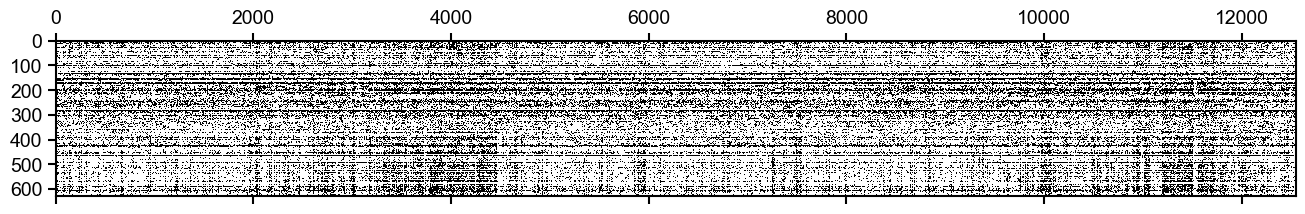

In [149]:
plt.matshow(sesh.spike_counts[:,halfpoint :], aspect= "auto", cmap='gray_r', vmin=0, vmax=np.percentile(sesh.spike_counts, 85), interpolation="none")


In [81]:
print(sesh.wh_speed)

[ 0.  0.  0. ... nan nan nan]


In [48]:
r_oa, r_wh = get_correlations(sesh.spike_counts, sesh.oa_speed, sesh.wh_speed, sesh.oa_pos, sesh.wh_pos, filter=False)

In [50]:
print(r_oa)
print(np.where(np.isnan(r_oa)))

[ 5.14419693e-02  2.22763759e-02 -9.67953519e-02 -9.23710612e-02
 -2.75888886e-02  2.66857506e-02 -1.09948438e-02 -5.37521770e-02
 -5.41686961e-02 -1.76707100e-02 -1.52128176e-01 -5.35778749e-02
 -1.63951664e-01 -9.83003211e-02 -1.39378358e-01 -5.77448393e-02
 -5.52317334e-02 -8.12571209e-02 -9.53709861e-02 -1.19149407e-01
 -2.61871181e-02 -2.37908747e-02 -7.87398512e-02 -8.44144490e-02
 -1.41903287e-01  1.82494056e-02  3.66045846e-02 -1.50810540e-01
 -5.40393909e-02 -6.23132839e-02 -2.41178338e-03 -6.05898079e-02
 -6.31795434e-02 -1.89322490e-02 -6.76605615e-02  2.56130634e-02
 -1.68788717e-01 -9.03919726e-02 -4.09718047e-02  8.21776099e-03
 -7.19603956e-02 -7.77122346e-02 -7.93395453e-02 -6.36957439e-02
 -1.48950135e-01 -1.32381703e-01 -5.51401101e-02 -3.87581764e-02
  1.49393965e-01  4.12740083e-02  2.40340345e-03 -6.12621167e-02
 -5.63015827e-02 -8.85788402e-02 -4.40649793e-02  2.13970955e-01
 -1.40979239e-04 -1.38526797e-02  3.60629522e-02  1.15909062e-02
  8.93290704e-03 -1.95540

In [43]:
print(sesh.spike_counts.shape)

(667, 40129)


In [ ]:
all_sessions = analyze_multiple_sessions(my_sessions)




In [ ]:
plot_all_sessions(all_sessions)

In [408]:
sesh = all_sessions[8]
print(len(sesh.context_invariant))
print(len(sesh.spike_counts))

564
564


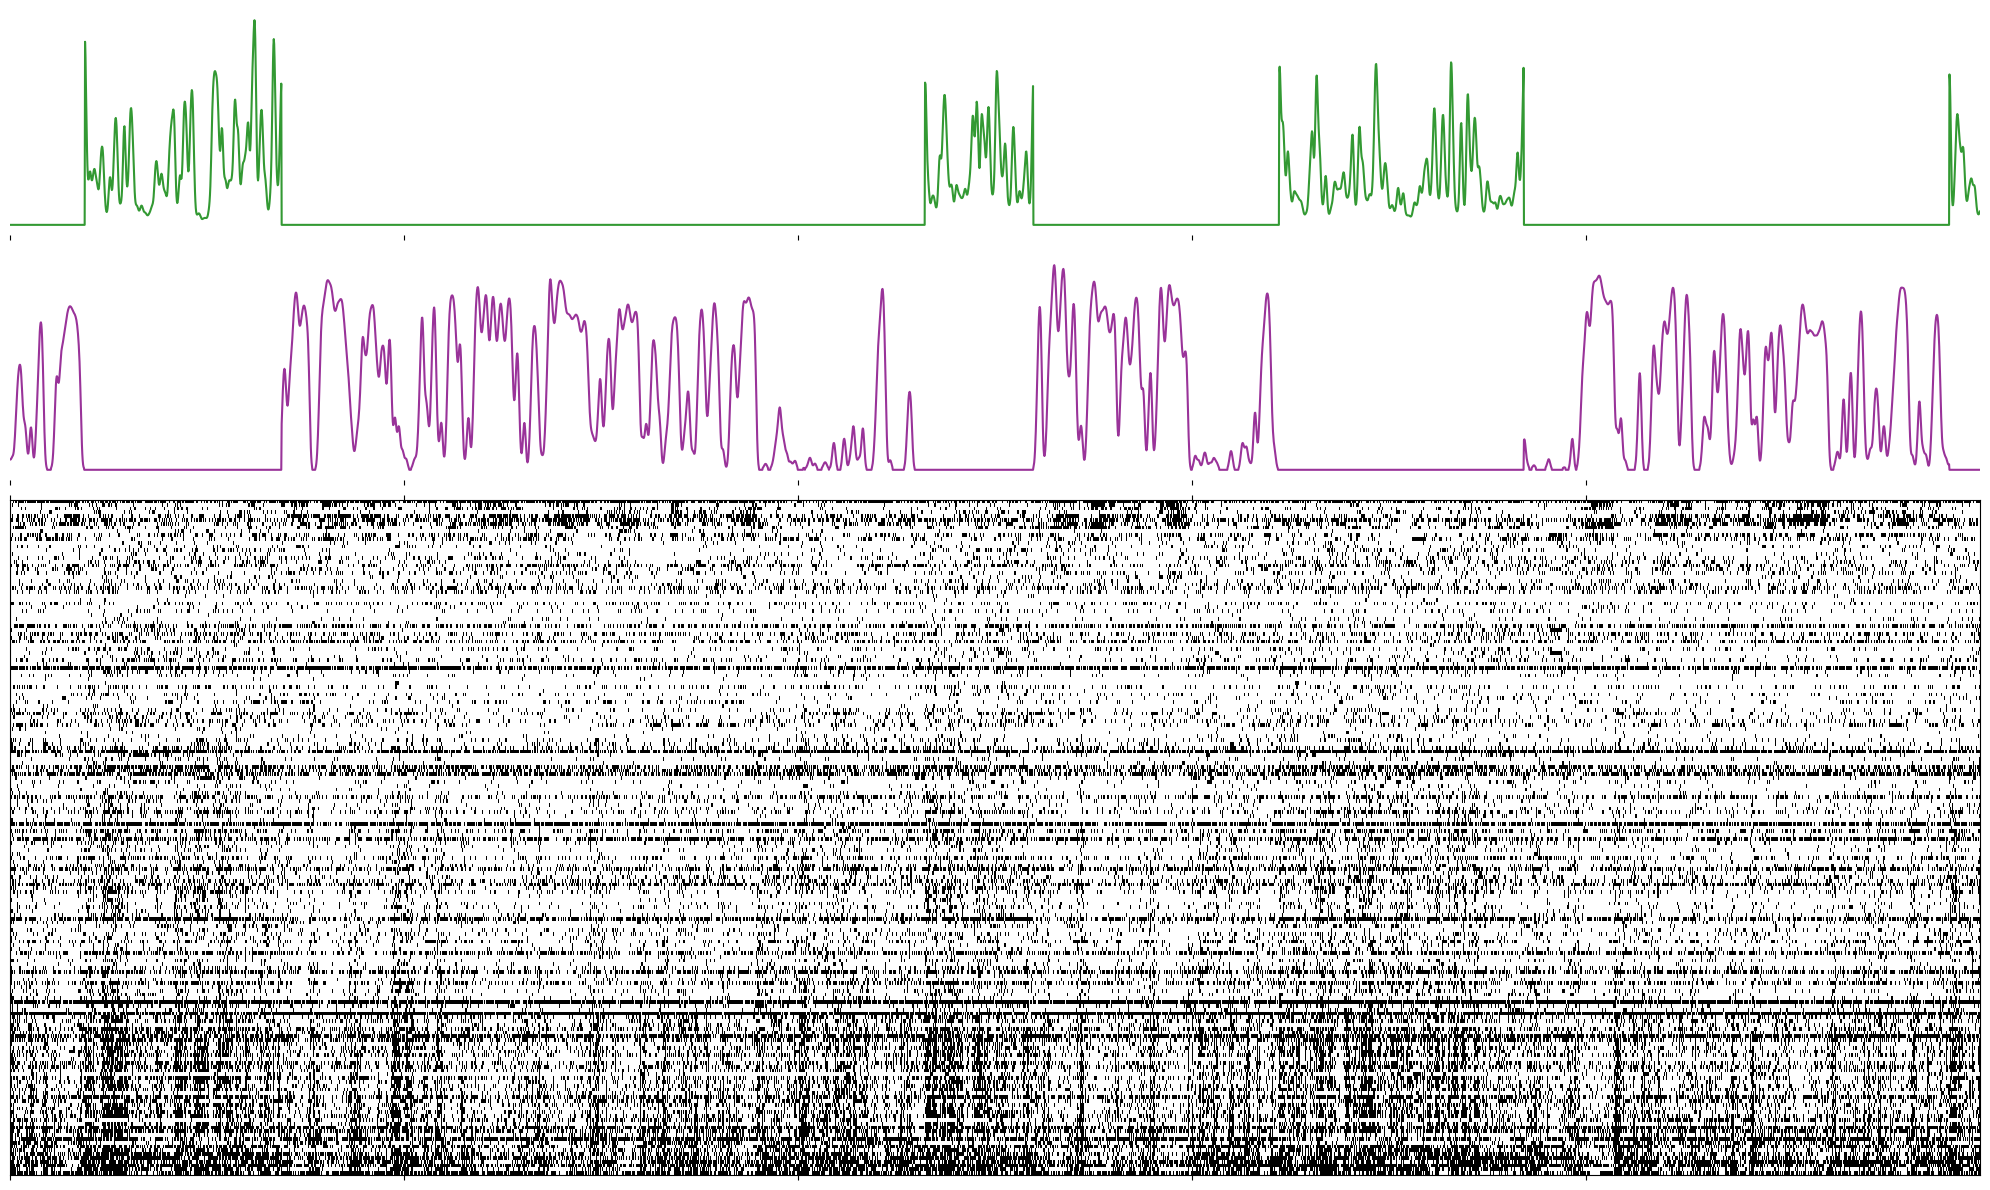

In [265]:


plot_sorted_spike_counts(sesh.r_wh[sesh.wheel_only], sesh.oa_speed, sesh.wh_speed, sesh.wh_running, sesh.oa_running, sesh.spike_counts[sesh.wheel_only,:], w_start=0, w_end=5000)



In [426]:
for session in all_sessions:
    n_neurons = session.spike_counts.shape[0]

    oa_speed_bins = np.linspace(0, np.nanmax(session.oa_speed), num=10)
    oa_speed_bin_centers = 0.5 * (oa_speed_bins[:-1] + oa_speed_bins[1:])
    wh_speed_bins = np.linspace(0, np.nanmax(session.wh_speed), num=10)
    wh_speed_bin_centers = 0.5 * (wh_speed_bins[:-1] + wh_speed_bins[1:])


    oa_firing_rates = np.zeros((n_neurons, len(oa_speed_bin_centers)))
    oa_speed_indices = np.digitize(session.oa_speed, oa_speed_bins) -1
    wh_firing_rates = np.zeros((n_neurons, len(wh_speed_bin_centers)))
    wh_speed_indices = np.digitize(session.wh_speed, wh_speed_bins) -1

    dt = 0.1


    for i in range (len(oa_speed_bin_centers)):
        idx =oa_speed_indices == i
        if np.any(idx):
            occupancy = np.sum(idx) * dt
            spikes_in_bin = session.spike_counts[:,idx].sum(axis=1)
            oa_firing_rates[:,i] = spikes_in_bin / occupancy
        else:
            oa_firing_rates[:,i] = np.nan


    for i in range (len(wh_speed_bin_centers)):
        idx =wh_speed_indices == i
        if np.any(idx):
            occupancy = np.sum(idx) * dt
            spikes_in_bin = session.spike_counts[:,idx].sum(axis=1)
            wh_firing_rates[:,i] = spikes_in_bin / occupancy
        else:
            wh_firing_rates[:,i] = np.nan

    slopes_oa = np.zeros(n_neurons)
    offsets_oa = np.zeros(n_neurons)
    r2_oa = np.zeros(n_neurons)
    slopes_wh = np.zeros(n_neurons)
    offsets_wh = np.zeros(n_neurons)
    r2_wh = np.zeros(n_neurons)

    for neuron in range(n_neurons):

        valid_oa = ~np.isnan(oa_firing_rates[neuron])
        valid_wh = ~np.isnan(wh_firing_rates[neuron])

        if np.sum(valid_oa) > 3:
            slopes_oa[neuron], offsets_oa[neuron] = np.polyfit(oa_speed_bin_centers[valid_oa], oa_firing_rates[neuron, valid_oa], 1)
            r2_oa[neuron] =1 - np.sum((oa_firing_rates[neuron, valid_oa] - (slopes_oa[neuron] * oa_speed_bin_centers[valid_oa] + offsets_oa[neuron]))**2) / np.sum((oa_firing_rates[neuron, valid_oa] - np.nanmean(oa_firing_rates[neuron, valid_oa]))**2)
        
        else:
            slopes_oa[neuron] = np.nan
            offsets_oa[neuron] = np.nan
            r2_oa[neuron] = np.nan

        if np.sum(valid_wh) > 3:
            slopes_wh[neuron], offsets_wh[neuron] = np.polyfit(wh_speed_bin_centers[valid_wh], wh_firing_rates[neuron, valid_wh], 1)
            r2_wh[neuron] =1 - np.sum((wh_firing_rates[neuron, valid_wh] - (slopes_wh[neuron] * wh_speed_bin_centers[valid_wh] + offsets_wh[neuron]))**2) / np.sum((wh_firing_rates[neuron, valid_wh] - np.nanmean(wh_firing_rates[neuron, valid_wh]))**2)
        
        else:
            slopes_wh[neuron] = np.nan
            offsets_wh[neuron] = np.nan
            r2_wh[neuron] = np.nan

    session.oa_slope = slopes_oa
    session.oa_offset = offsets_oa
    session.oa_r2 = r2_oa
    session.wh_slope = slopes_wh
    session.wh_offset = offsets_wh
    session.wh_r2 = r2_wh


In [ ]:
for session in all_sessions:
    n_neurons = session.spike_counts.shape[0]

slopes_oa = np.zeros(n_neurons)
offsets_oa = np.zeros(n_neurons)
r2_oa = np.zeros(n_neurons)
slopes_wh = np.zeros(n_neurons)
offsets_wh = np.zeros(n_neurons)
r2_wh = np.zeros(n_neurons)

for neuron in range(n_neurons):

    valid_oa = ~np.isnan(oa_firing_rates[neuron])
    valid_wh = ~np.isnan(wh_firing_rates[neuron])

    if np.sum(valid_oa) > 3:
        slopes_oa[neuron], offsets_oa[neuron] = np.polyfit(oa_speed_bin_centers[valid_oa], oa_firing_rates[neuron, valid_oa], 1)
        r2_oa[neuron] =1 - np.sum((oa_firing_rates[neuron, valid_oa] - (slopes_oa[neuron] * oa_speed_bin_centers[valid_oa] + offsets_oa[neuron]))**2) / np.sum((oa_firing_rates[neuron, valid_oa] - np.nanmean(oa_firing_rates[neuron, valid_oa]))**2)
        
    else:
        slopes_oa[neuron] = np.nan
        offsets_oa[neuron] = np.nan
        r2_oa[neuron] = np.nan

    if np.sum(valid_wh) > 3:
        slopes_wh[neuron], offsets_wh[neuron] = np.polyfit(wh_speed_bin_centers[valid_wh], wh_firing_rates[neuron, valid_wh], 1)
        r2_wh[neuron] =1 - np.sum((wh_firing_rates[neuron, valid_wh] - (slopes_wh[neuron] * wh_speed_bin_centers[valid_wh] + offsets_wh[neuron]))**2) / np.sum((wh_firing_rates[neuron, valid_wh] - np.nanmean(wh_firing_rates[neuron, valid_wh]))**2)
        
    else:
        slopes_wh[neuron] = np.nan
        offsets_wh[neuron] = np.nan
        r2_wh[neuron] = np.nan

    session.oa_slope = slopes_oa
    session.oa_offset = offsets_oa
    session.oa_r2 = r2_oa
    session.wh_slope = slopes_wh
    session.wh_offset = offsets_wh
    session.wh_r2 = r2_wh


In [526]:
explore = all_sessions[7]
subject_id = explore.subject_id
date = explore.date
print(f"Exploring session for {subject_id} on {date}")

Exploring session for EB037 on 2024-03-20


Text(0.5, 1.0, 'Intercept Comparison')

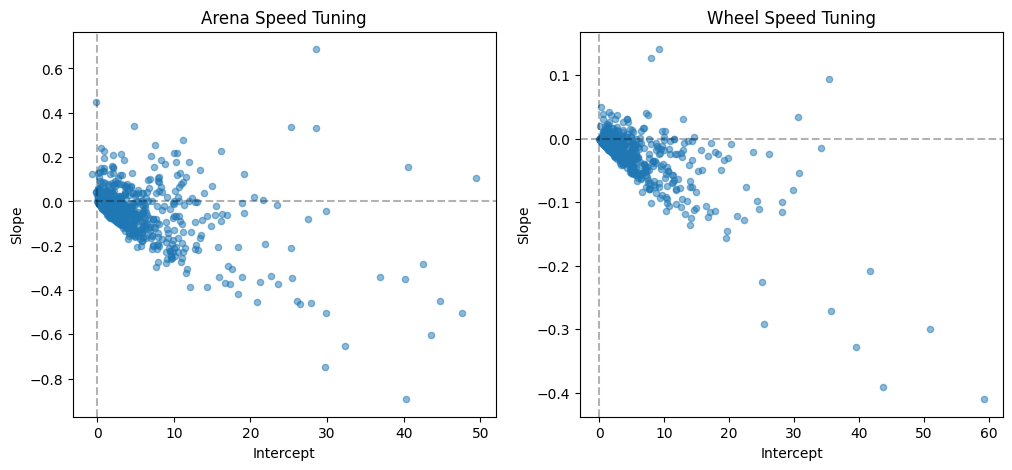

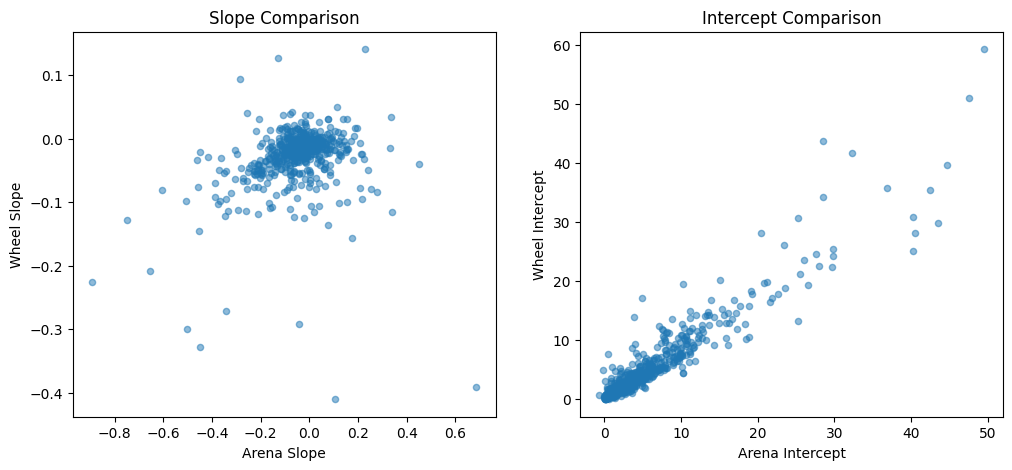

In [518]:



    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#well_fit = (explore.oa_r2 > 0.5) | (explore.wh_r2 > 0.5)

# Arena tuning
ax1.scatter(explore.oa_offset, explore.oa_slope, alpha=0.5, s=20)
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_xlabel('Intercept')
ax1.set_ylabel('Slope')
ax1.set_title('Arena Speed Tuning')

# Wheel tuning
ax2.scatter(explore.wh_offset, explore.wh_slope, alpha=0.5, s=20)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Intercept')
ax2.set_ylabel('Slope')
ax2.set_title('Wheel Speed Tuning')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Compare slopes across contexts
ax1.scatter(explore.oa_slope, explore.wh_slope, alpha=0.5, s=20)
ax1.set_xlabel('Arena Slope')
ax1.set_ylabel('Wheel Slope')
ax1.set_title('Slope Comparison')

# Compare offsets across contexts
ax2.scatter(explore.oa_offset, explore.wh_offset, alpha=0.5, s=20)
ax2.set_xlabel('Arena Intercept')
ax2.set_ylabel('Wheel Intercept')
ax2.set_title('Intercept Comparison')



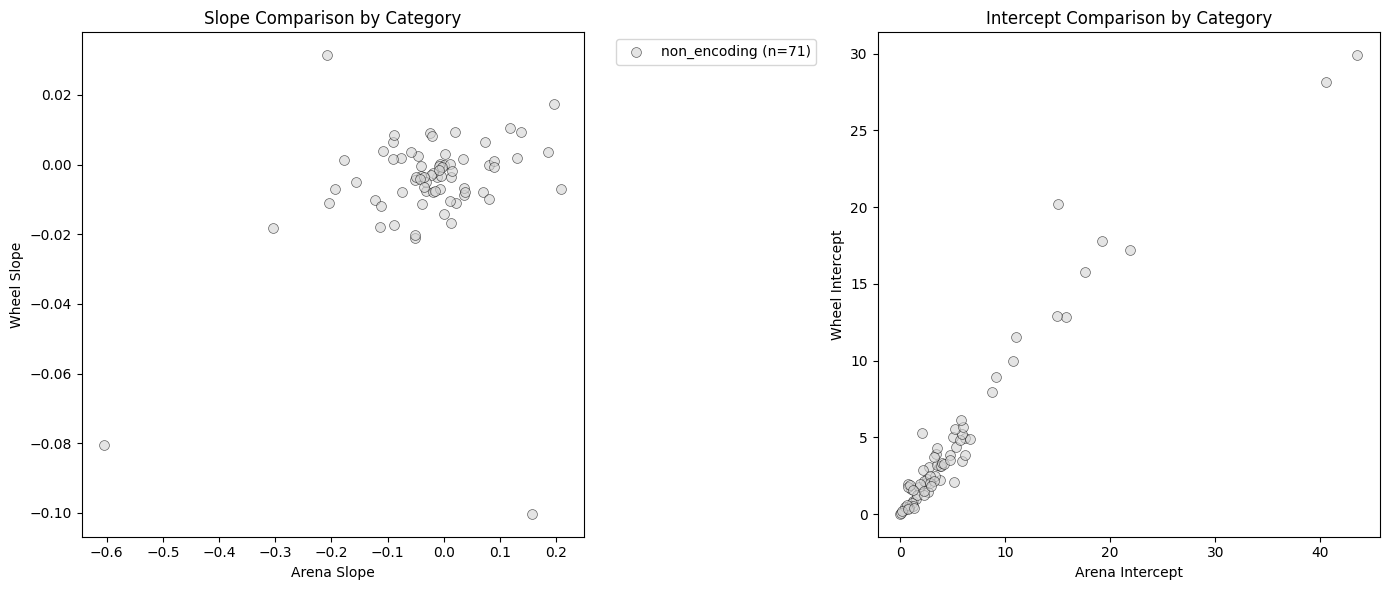

In [524]:
# Define colors for each category
colors = {
    #'context_invariant': 'black',
    #'arena_only': 'green', 
    #'wheel_only': 'purple',
    #'context_switching': 'orange',
    'non_encoding': 'lightgray'
}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot each category separately
for cat, color in colors.items():
    if hasattr(explore, cat):
        mask = getattr(explore, cat) #& well_fit
        if np.sum(mask) > 0:
            ax1.scatter(explore.oa_slope[mask], explore.wh_slope[mask], 
                       c=color, label=f'{cat} (n={np.sum(mask)})', 
                       alpha=0.6, s=50, edgecolor='k', linewidth=0.5)

            ax2.scatter(explore.oa_offset[mask], explore.wh_offset[mask], 
                       c=color, alpha=0.6, s=50, edgecolor='k', linewidth=0.5)


ax1.set_xlabel('Arena Slope')
ax1.set_ylabel('Wheel Slope')
ax1.set_title('Slope Comparison by Category')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

max_offset = np.nanmax(np.concatenate([explore.oa_offset, explore.wh_offset]))
ax2.set_xlabel('Arena Intercept')
ax2.set_ylabel('Wheel Intercept')
ax2.set_title('Intercept Comparison by Category')

plt.tight_layout()

In [120]:

def get_reliability_Stability(session):

        r_oa_1= session.r_oa_first_half
        r_oa_2 = session.r_oa_second_half
        r_wh_1= session.r_wh_first_half
        r_wh_2= session.r_wh_second_half
        r_oa_1_2 = session.oa_stability
        r_wh_1_2 = session.wh_stability


        r_oa_1_wh_2 = np.corrcoef(r_oa_1, r_wh_2) [0,1]
        r_oa_2_wh_1 = np.corrcoef(r_oa_2, r_wh_1) [0,1]


        session.reliability = np.sqrt(r_oa_1_2* r_wh_1_2) 

        
        z1 = np.arctanh(r_oa_1_wh_2)
        z2 = np.arctanh(r_oa_2_wh_1)

        z_mean = (z1 + z2 ) / 2
        session.stability = np.tanh(z_mean)

In [ ]:
def plot_reliability_stability(all_session):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['xtick.major.width'] = 1.5
    plt.rcParams['ytick.major.width'] = 1.5
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6

    fig, ax = plt.subplots(1, 1, figsize=(7, 7), dpi=300)

    reliability_values = []
    stability_values = []
    brain_regions = []

    for session in all_sessions:
        
        reliability_values.append(session.reliability)
        stability_values.append(session.stability)
        
    
        if session.subject_id[:2] == 'EB':
            brain_regions.append('Hippocampus')
        else:
            brain_regions.append('Secondary Motor Cortex')


    reliability_values = np.array(reliability_values)
    stability_values = np.array(stability_values)
    brain_regions = np.array(brain_regions)


    colors = {
        'Hippocampus':"#132B97",  
        'Secondary Motor Cortex':"#690B0B" 
    }  
    for region in ['Hippocampus', 'Secondary Motor Cortex']:
        mask = brain_regions == region
        
        ax.scatter(reliability_values[mask], 
                stability_values[mask], 
                c=colors[region],
                s=100,  
                alpha=0.7,  
                edgecolors='none',  
                linewidth=0.5,
                label=region,
                zorder=3)

    ax.plot([0, 1], [0, 1], 'k-', linewidth=1.5, alpha=0.5, zorder=1)

    ax.set_xlim(-0.10, 1.05)
    ax.set_ylim(-0.10, 1.05)

    ax.set_xlabel('reliability within context', fontsize=16)
    ax.set_ylabel('stability between contexts', fontsize=16)

    # Add legend
    legend = ax.legend(loc='upper left', 
                    frameon=True, 
                    fancybox=False,
                    edgecolor='black',
                    fontsize=12)
    legend.get_frame().set_linewidth(0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)


    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()

In [118]:
sesh =load_and_process_session(subject_id, date, target_freq=10)
sesh = analyze_single_session(sesh)


(array([], dtype=int64),)
DEBUG: n_neurons = 819
DEBUG: Arena mask sum = 39258 / 55129 time points
DEBUG: Wheel mask sum = 15642 / 55129 time points
DEBUG: Arena speed shape = (55129,), unique values = 55128
DEBUG: Wheel speed shape = (55129,), unique values = 26849
DEBUG: Total spikes in arena = 7629167.0
DEBUG: Total spikes in wheel = 3318447.0
DEBUG: Neurons with arena variance > 0: 819
DEBUG: Neurons with wheel variance > 0: 819
DEBUG: Good neurons = 819 / 819
DEBUG: r_oa NaNs = 0
DEBUG: r_wh NaNs = 0
DEBUG: r_oa range = [-0.186, 0.320]
DEBUG: r_wh range = [-0.344, 0.370]
DEBUG: Arena speed variance = 7.94207171427573
DEBUG: Wheel speed variance = 143.90923496567723


NameError: name 'all_sessions' is not defined

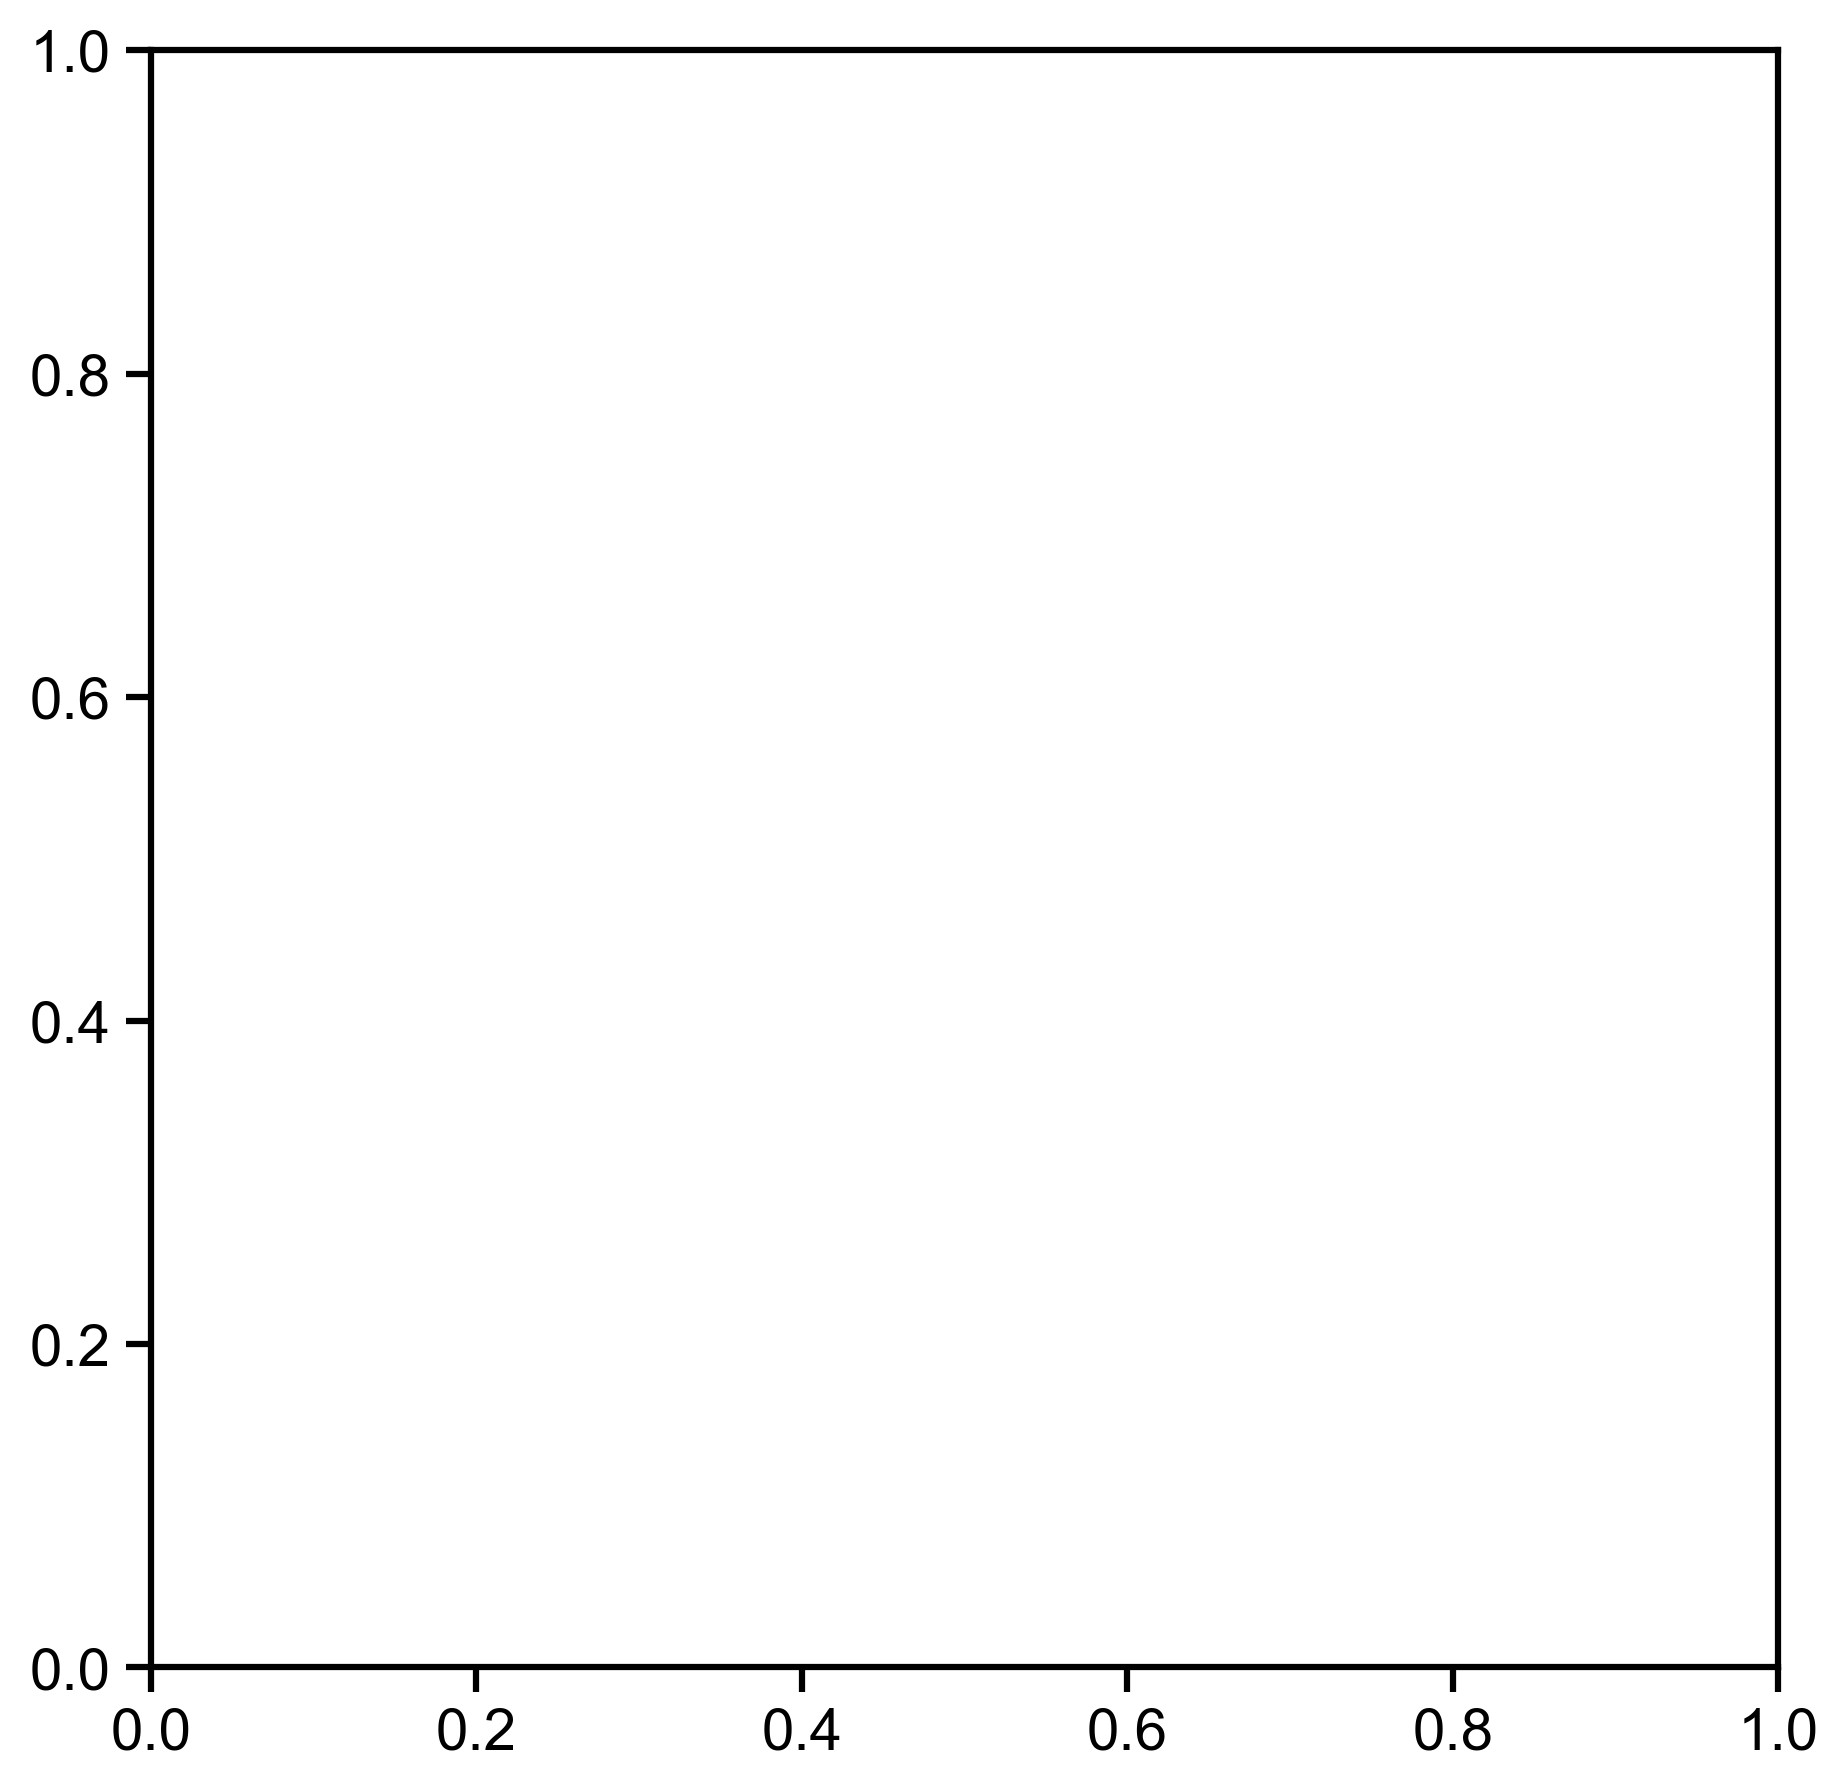

In [124]:
get_reliability_Stability(sesh)
plot_reliability_stability(sesh)


neck: 482 NaN frames for x (0.3%)
neck: 482 NaN frames for y (0.3%)
mid_back: 1371 NaN frames for x (0.9%)
mid_back: 1371 NaN frames for y (0.9%)
mouse_center: 206 NaN frames for x (0.1%)
mouse_center: 206 NaN frames for y (0.1%)
mid_backend: 460 NaN frames for x (0.3%)
mid_backend: 460 NaN frames for y (0.3%)
mid_backend2: 1770 NaN frames for x (1.2%)
mid_backend2: 1770 NaN frames for y (1.2%)
mid_backend3: 2292 NaN frames for x (1.5%)
mid_backend3: 2292 NaN frames for y (1.5%)


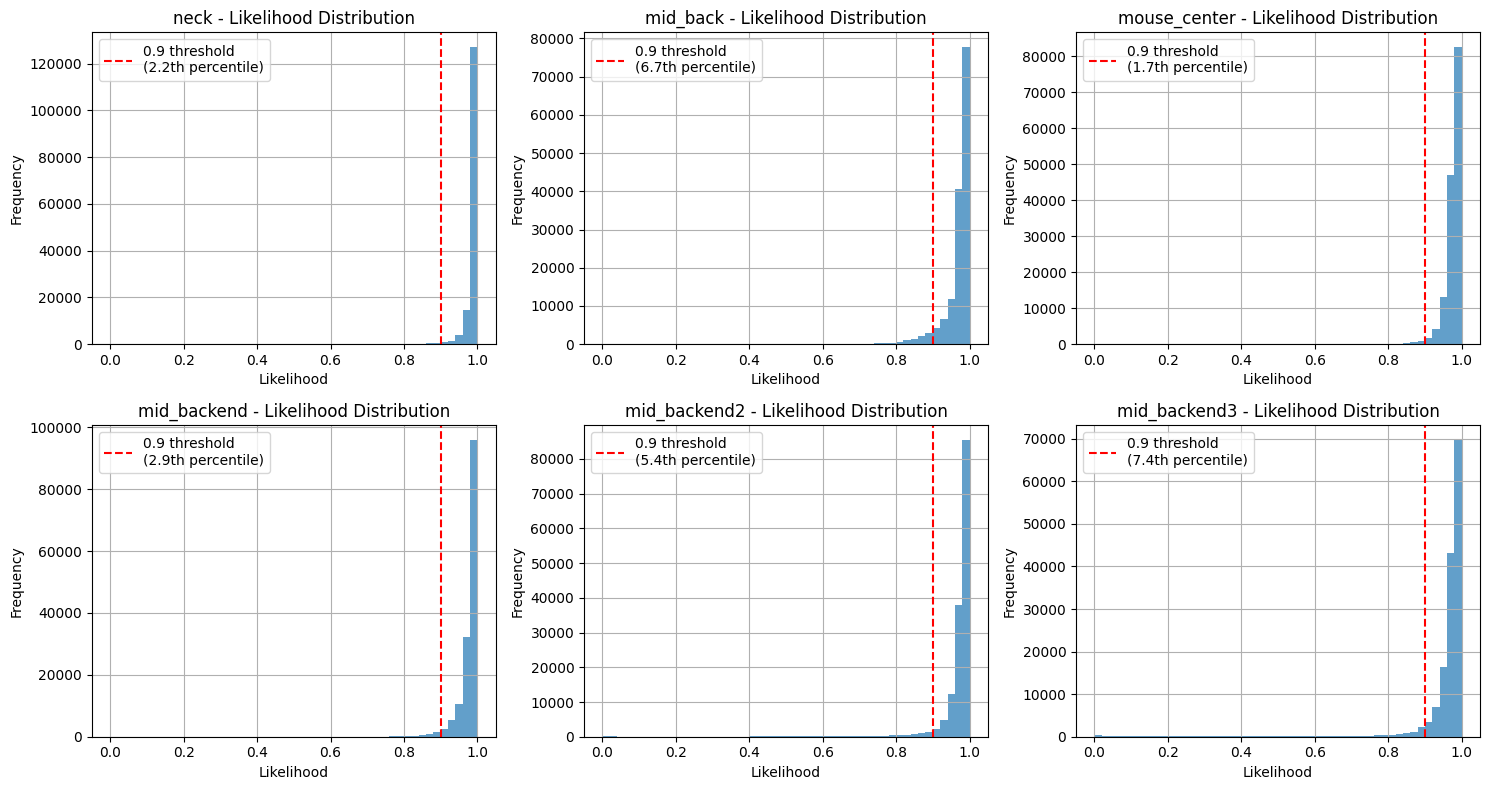

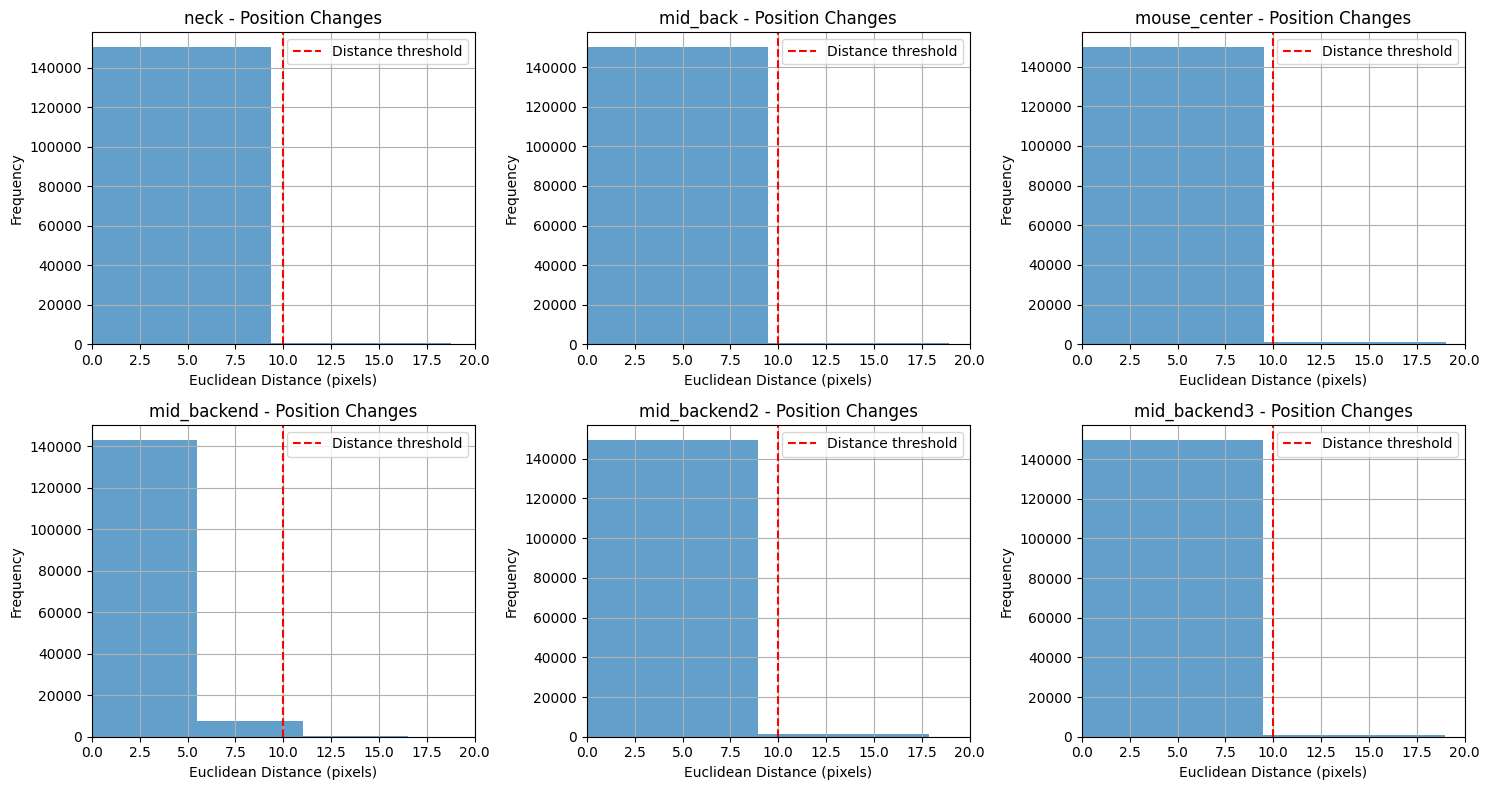

neck: 482 NaN frames for x (0.3%)
neck: 482 NaN frames for y (0.3%)
mid_back: 1371 NaN frames for x (0.9%)
mid_back: 1371 NaN frames for y (0.9%)
mouse_center: 206 NaN frames for x (0.1%)
mouse_center: 206 NaN frames for y (0.1%)
mid_backend: 460 NaN frames for x (0.3%)
mid_backend: 460 NaN frames for y (0.3%)
mid_backend2: 1770 NaN frames for x (1.2%)
mid_backend2: 1770 NaN frames for y (1.2%)
mid_backend3: 2292 NaN frames for x (1.5%)
mid_backend3: 2292 NaN frames for y (1.5%)


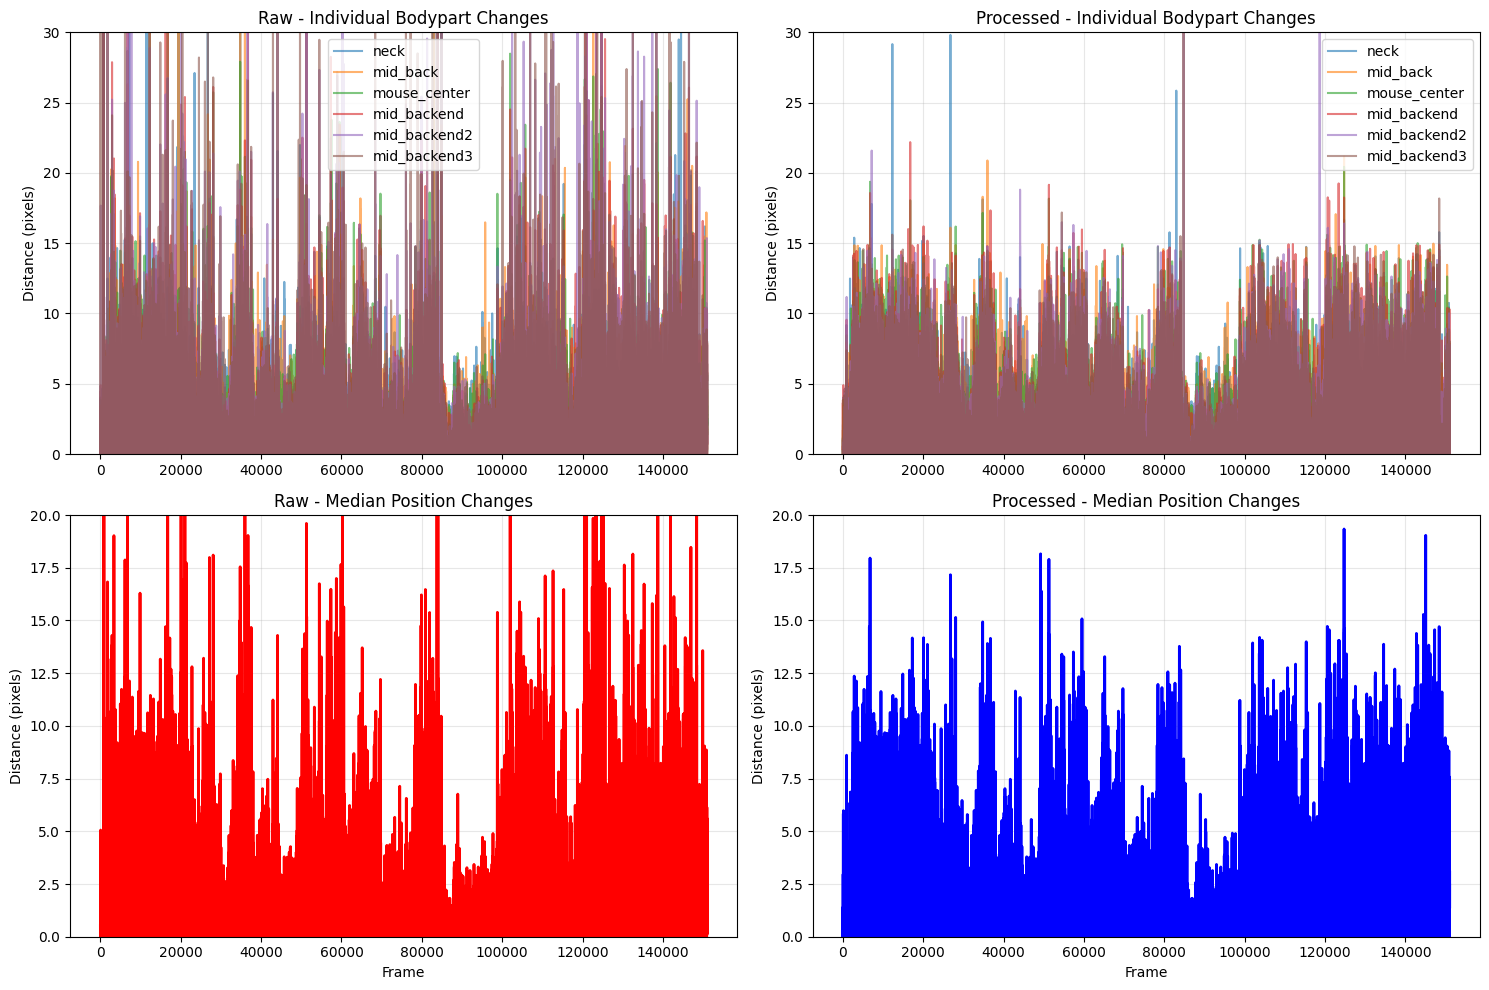

In [12]:
dlc_df = get_dlc_df(subject_id, date)
preprocess_dlc_data(dlc_df)
plot_dlc_analyses(dlc_df, w_start=0, w_end=400000)